In [1]:
import os
import cv2
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt

In [2]:
import kagglehub

path = kagglehub.dataset_download("ugorjiir/gun-detection")
print("Path to dataset files:", path)

# جستجوی خودکار برای پیدا کردن پوشه تصاویر
found_path = ""
for root, dirs, files in os.walk(path):
    if any(f.endswith('.jpg') for f in files):
        found_path = root
        break

if found_path:
    dataset_path = found_path
    print(f" مسیر درست پیدا شد: {dataset_path}")

    # خواندن تصویر تست
    try:
        files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
        sample_img_path = os.path.join(dataset_path, files[0])
        img = cv2.imread(sample_img_path)

        if img is None:
            print(" ارور: فایل تصویر آسیب دیده یا خوانده نمی‌شود.")
        else:
            print(f" عکس با موفقیت بارگذاری شد. ابعاد: {img.shape}")
    except Exception as e:
        print(f" ارور در خواندن فایل: {e}")
else:
    print(" هیچ فایل jpg در این مسیر پیدا نشد. لطفاً دیتاست را چک کنید.")

100%|██████████| 265M/265M [00:02<00:00, 107MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ugorjiir/gun-detection/versions/1
 مسیر درست پیدا شد: /root/.cache/kagglehub/datasets/ugorjiir/gun-detection/versions/1/Gunmen Dataset/All
 عکس با موفقیت بارگذاری شد. ابعاد: (720, 1280, 3)


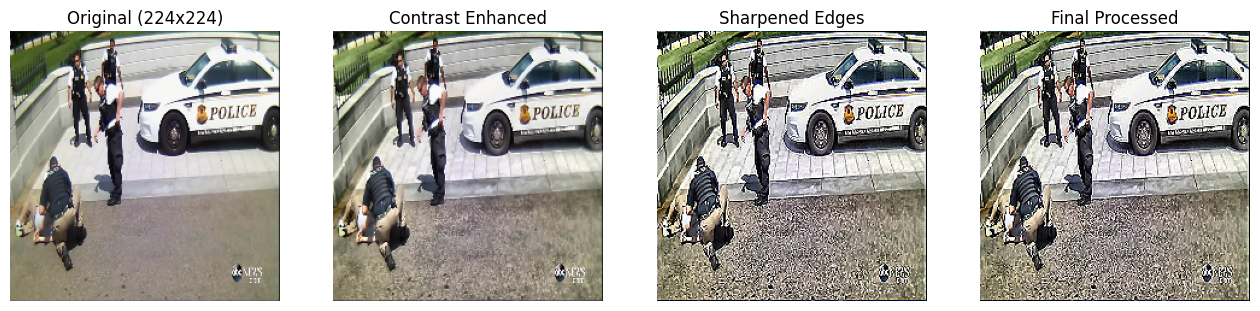

In [3]:
# خواندن اولین تصویر برای تست
try:
    files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
    sample_img_path = os.path.join(dataset_path, files[0])
    img = cv2.imread(sample_img_path)
except:
    img = None

def image_processing_pipeline(image):
    if image is None: return None

    # تغییر اندازه به 224
    res = cv2.resize(image, (224, 224))

    # بهبود کنتراست هوشمند (CLAHE)
    lab = cv2.cvtColor(res, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img_clahe = cv2.merge((clahe.apply(l), a, b))
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2BGR)

    # فیلتر Sharpening برای لبه‌ها
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharp = cv2.filter2D(img_clahe, -1, kernel)

    # افزودن نویز گوسی
    noise = np.random.normal(0, 2, img_sharp.shape)
    # محدود کردن بین 0 و 255
    img_final = np.clip(img_sharp.astype(np.float32) + noise, 0, 255).astype('uint8')

    return res, img_clahe, img_sharp, img_final

# اجرای پردازش و نمایش
if img is not None:
    res, contrast, sharp, final = image_processing_pipeline(img)
    titles = ['Original (224x224)', 'Contrast Enhanced', 'Sharpened Edges', 'Final Processed']
    imgs = [res, contrast, sharp, final]

    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()
else:
    print("خطا: تصویر برای پردازش پیدا نشد!")

In [4]:
input_path = found_path
output_path = "/content/weapon_data_v3"
os.makedirs(output_path, exist_ok=True)

def advanced_processing(img):
    # استانداردسازی به 224
    img = cv2.resize(img, (224, 224))

    # بهبود کنتراست هوشمند (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img = cv2.merge((clahe.apply(l), a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)

    # فیلتر Sharpening برای لبه‌ها
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    # افزودن نویز گوسی ملایم
    noise = np.random.normal(0, 2, img.shape)
    img = np.clip(img.astype(np.float32) + noise, 0, 255).astype('uint8')

    return img

print("شروع تولید دیتاست ۵۶۸۷ تصویری با ابعاد ۲۲۴...")

final_count = 0
# مرکز برای تصویر 224
center = (112, 112)

for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(input_path, filename)
        image = cv2.imread(img_path)
        if image is None: continue

        # تصویر اصلی پردازش شده
        base = advanced_processing(image)
        cv2.imwrite(os.path.join(output_path, f"base_{filename}"), base)

        # چرخش ۱۵ درجه (Rotation)
        M_rot = cv2.getRotationMatrix2D(center, 15, 1.0)
        rotated = cv2.warpAffine(base, M_rot, (224, 224))
        cv2.imwrite(os.path.join(output_path, f"rot_{filename}"), rotated)

        # معکوس کردن (Flip)
        flipped = cv2.flip(base, 1)
        cv2.imwrite(os.path.join(output_path, f"flip_{filename}"), flipped)

        # تغییر مقیاس/زوم (Scaling)
        M_zoom = cv2.getRotationMatrix2D(center, 0, 1.2) # 20% زوم
        zoomed = cv2.warpAffine(base, M_zoom, (224, 224))
        cv2.imwrite(os.path.join(output_path, f"zoom_{filename}"), zoomed)

        # کپی برچسب‌ها برای تمام ۴ نسخه
        label_file = filename.replace('.jpg', '.txt')
        if os.path.exists(os.path.join(input_path, label_file)):
            with open(os.path.join(input_path, label_file), 'r') as f:
                content = f.read()
            for prefix in ['base_', 'rot_', 'flip_', 'zoom_']:
                with open(os.path.join(output_path, prefix + label_file), 'w') as f:
                    f.write(content)

        final_count += 4

print(f"عملیات تمام شد! تعداد تصاویر: {final_count}")

شروع تولید دیتاست ۵۶۸۷ تصویری با ابعاد ۲۲۴...
عملیات تمام شد! تعداد تصاویر: 5240


In [5]:
src_dir = '/content/weapon_data_v3'
base_output = '/content/final_weapon_dataset'

# ایجاد ساختار پوشه‌های استاندارد برای YOLO
for s in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_output, 'images', s), exist_ok=True)
    os.makedirs(os.path.join(base_output, 'labels', s), exist_ok=True)

# لیست کردن و مخلوط کردن تمام تصاویر برای آموزش عادلانه
all_images = [f for f in os.listdir(src_dir) if f.endswith('.jpg')]
random.shuffle(all_images)

total = len(all_images)
train_end = int(total * 0.7) # 70% آموزش
val_end = train_end + int(total * 0.2) # 20% اعتبار

print(f"در حال سازمان‌دهی {total} تصویر در ابعاد 224x224...")

for i, filename in enumerate(all_images):
    # تعیین پوشه مقصد بر اساس شاخص i
    if i < train_end: subset = 'train'
    elif i < val_end: subset = 'val'
    else: subset = 'test'

    # انتقال تصویر به پوشه مربوطه
    shutil.copy(os.path.join(src_dir, filename),
                os.path.join(base_output, 'images', subset, filename))

    # ۳. اصلاح و انتقال برچسب
    label_name = filename.replace('.jpg', '.txt')
    label_src = os.path.join(src_dir, label_name)

    if os.path.exists(label_src):
        with open(label_src, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.split()
            # تغییر ID از دیتاست اصلی به IDهای استاندارد ما
            if parts[0] == '16': parts[0] = '0'   # Gun -> 0
            elif parts[0] == '15': parts[0] = '1' # Human -> 1
            new_lines.append(" ".join(parts) + "\n")

        # ذخیره فایل برچسب در پوشه استاندارد
        with open(os.path.join(base_output, 'labels', subset, label_name), 'w') as f:
            f.writelines(new_lines)

# تولید فایل data.yaml
yaml_content = f"""
train: {base_output}/images/train
val: {base_output}/images/val
test: {base_output}/images/test
nc: 2
names: ['Gun', 'Human']
"""
with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

print(f" عملیات با موفقیت تمام شد! دیتای نهایی در {base_output} آماده است.")

در حال سازمان‌دهی 5240 تصویر در ابعاد 224x224...
 عملیات با موفقیت تمام شد! دیتای نهایی در /content/final_weapon_dataset آماده است.


In [6]:
yaml_content = f"""
train: /content/final_weapon_dataset/images/train
val: /content/final_weapon_dataset/images/val
test: /content/final_weapon_dataset/images/test

nc: 2 # تعداد کلاس‌ها (اسلحه و انسان)
names: ['Gun', 'Human'] # نام کلاس‌ها به ترتیب ID
"""

# ذخیره فایل در مسیر اصلی پروژه
with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content.strip()) # استفاده از strip برای حذف فواصل خالی ابتدا و انتها

print(" فایل data.yaml با موفقیت ساخته شد و با کلاس‌های اصلاح شده (0: Gun, 1: Human) هماهنگ است.")

 فایل data.yaml با موفقیت ساخته شد و با کلاس‌های اصلاح شده (0: Gun, 1: Human) هماهنگ است.


In [7]:
!pip install ultralytics

from ultralytics import YOLO
import torch

# ۲. چک کردن اینکه آیا کارت گرافیک فعال شده یا نه
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"آموزش روی این سخت‌افزار اجرا می‌شود: {device}")

# ۳. بارگذاری مدل Small
model = YOLO('yolov8s.pt')

# ۴. شروع آموزش بهینه شده
results = model.train(
    data='/content/data.yaml',
    epochs=100,           # تعداد دور (Epoch) طبق مقاله
    imgsz=224,            # افزایش ابعاد به 224 برای دقت بالاتر در تشخیص اسلحه
    batch=16,             # تعداد تصاویر همزمان
    device=device,        # استفاده اجباری از کارت گرافیک (GPU)
    name='weapon_model_v2',
    optimizer='AdamW',    # بهینه‌ساز قوی‌تر برای رسیدن به دقت ۹۸٪
    lr0=0.01              # نرخ یادگیری اولیه
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
آموزش روی این سخت‌افزار اجرا می‌شود: 0
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, forma


image 1/1 /content/final_weapon_dataset/images/test/rot_White House Shooting  Secret Service Shoot Gun-wielding Man [CAUGHT ON TAPE] (519).jpg: 224x224 7 Humans, 8.6ms
Speed: 0.6ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/final_weapon_dataset/images/test/base_CNN has obtained videos from inside the Westgate Mall (38).jpg: 224x224 1 Human, 7.4ms
Speed: 0.4ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/final_weapon_dataset/images/test/flip_White House Shooting  Secret Service Shoot Gun-wielding Man [CAUGHT ON TAPE] (520).jpg: 224x224 6 Humans, 7.4ms
Speed: 0.4ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)


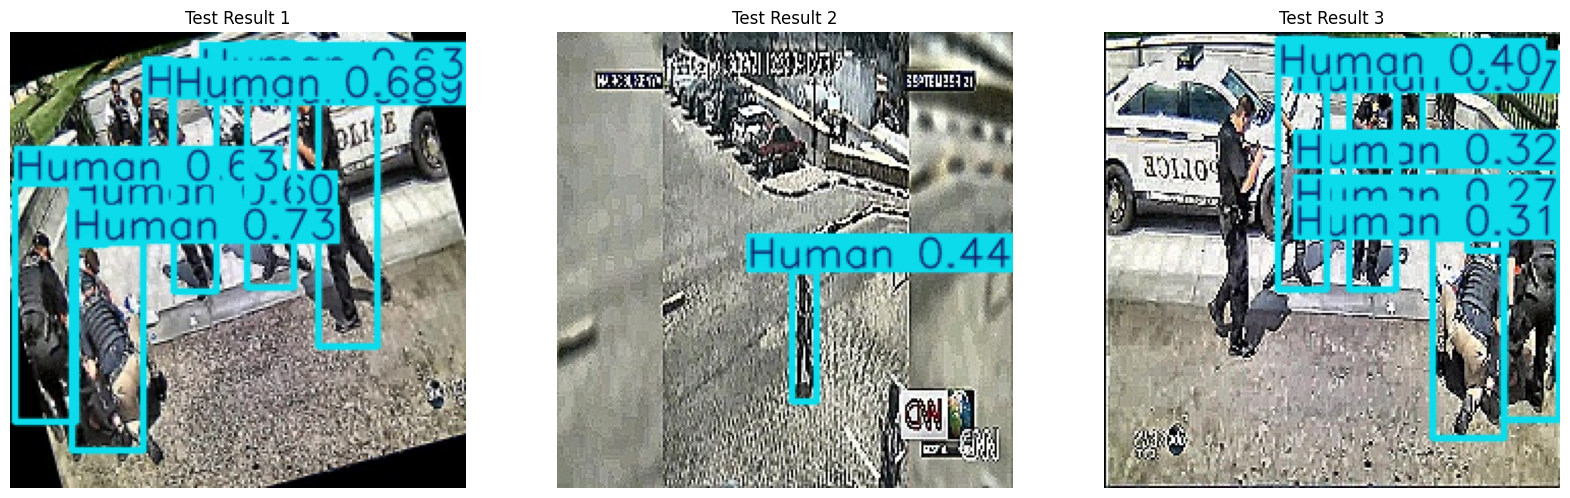

خروجی مدل


In [9]:
# بارگذاری بهترین مدل ساخته شده (best.pt)
model_path = '/content/runs/detect/weapon_model_v2/weights/best.pt'
model = YOLO(model_path)

test_images_path = '/content/final_weapon_dataset/images/test'
test_images = [os.path.join(test_images_path, f) for f in os.listdir(test_images_path) if f.endswith('.jpg')]

samples = random.sample(test_images, 3)
plt.figure(figsize=(20, 10))

for i, img_path in enumerate(samples):
    # اجرای مدل روی عکس (با آستانه اطمینان 0.25)
    results = model.predict(source=img_path, imgsz=224, conf=0.25)

    res_plotted = results[0].plot()

    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.title(f"Test Result {i+1}")
    plt.axis('off')

plt.show()

print("خروجی مدل")

In [11]:
import shutil
from google.colab import files

# زیپ کردن پوشه نتایج نهایی
folder_to_zip = '/content/runs/detect/weapon_model_v2'
output_filename = 'Weapon_Detection_Final_Results'

shutil.make_archive(output_filename, 'zip', folder_to_zip)

# دانلود فایل زیپ به کامپیوتر شما
files.download(f'{output_filename}.zip')

print(" فایل نتایج (شامل نمودارها و مدل) در حال دانلود است...")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 فایل نتایج (شامل نمودارها و مدل) در حال دانلود است...
